In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
import networkx as nx
import plotly.graph_objects as go

import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import plotly.io as pio

In [2]:
xlsx_path = './Data/BK/20240909 Visualization (Adolescent).xlsx'

In [3]:
df = pd.read_excel(xlsx_path).dropna()
df.columns

Index(['ID', 'Chronic TMD ', 'VAS-I', 'Treatment duration ', 'Female ', 'Age',
       'VAS-F', 'TMJ OA on PR', 'ADD on MRI', 'TMJ OA on MRI ', 'TMJ noise ',
       'TMD pain ', 'Muscle stiffness ', 'Locking ', 'Bruxism ',
       'Uncomfortable occlusion', 'Tinnitus ', 'Psychological distress ',
       'Sleep problem ', 'Headache ', 'Orthodontic tx', 'Bad posture ',
       'Irregular diet ', 'Anterior joint space ', 'Posterior joint space ',
       'Naso-maxillary discrepancy', 'Maxillo-mandibular discrepancy',
       'Body length discrepancy', 'Ramus height discrepancy '],
      dtype='object')

In [4]:
df.rename(columns={'Chronic TMD ' : 'Chronic TMD', 'Acute0Chronic1': 'Chronic TMD', 'STOP-Bang 3': 'STOP-Bang>=3', 'STOP-Bang 5': 'STOP-Bang>=5', 'SEX_M1F2' : 'Female'}, inplace=True)
#df = df.drop(columns=['ID'])
df

,ID,Chronic TMD,VAS-I,Treatment duration,Female,Age,VAS-F,TMJ OA on PR,ADD on MRI,TMJ OA on MRI,...,Headache,Orthodontic tx,Bad posture,Irregular diet,Anterior joint space,Posterior joint space,Naso-maxillary discrepancy,Maxillo-mandibular discrepancy,Body length discrepancy,Ramus height discrepancy
0,14907015,0,6,13.0,1,10,2,1,1,1,...,0,0,1,1,3.065,1.940,2.20,2.80,4.14,3.01
1,14045763,0,6,7.0,1,12,1,0,0,0,...,0,1,0,0,1.840,2.885,2.60,2.40,2.68,5.26
2,14887551,0,0,8.0,2,12,0,1,1,1,...,0,0,0,0,2.630,3.440,0.00,0.00,5.83,0.74
3,14773426,0,3,0.0,2,12,0,0,0,1,...,0,1,1,0,1.945,2.300,0.00,0.00,1.37,1.84
4,12144867,0,0,0.0,2,12,0,0,0,0,...,1,0,1,0,2.955,3.505,0.00,0.00,0.09,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,12722237,1,5,15.0,2,18,0,0,1,0,...,0,0,1,0,2.020,3.010,1.47,0.00,2.06,5.01
154,14872693,1,2,4.0,1,18,0,0,1,0,...,0,0,0,0,1.980,3.185,0.00,1.94,4.93,0.19
155,14918483,1,2,6.0,1,18,0,0,1,0,...,0,0,1,0,2.355,2.630,1.69,0.00,2.82,3.38
156,11986664,1,8,10.0,2,18,0,0,1,1,...,0,0,0,0,2.360,2.725,1.55,0.00,1.72,1.07


In [5]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_clustering_graph(df, target_column, center_color='orange', save_path=''):
    # 상관행렬 계산
    corr_matrix = df.corr()
    
    # 그래프 생성
    G = nx.Graph()
    
    # 노드 추가
    for col in corr_matrix.columns:
        G.add_node(col)
    
    # 중심 변수와 다른 변수들 간의 상관관계를 간선으로 추가
    edges = []
    for col in corr_matrix.columns:
        if col != target_column:
            weight = corr_matrix[target_column][col]
            edges.append((target_column, col, abs(weight)))
    
    # 그래프에 간선 추가
    for u, v, weight in edges:
        G.add_edge(u, v, weight=weight)
    
    # 노드 위치 설정
    pos = nx.spring_layout(G, k=0.5, seed=42)  # k값 조절로 겹침 방지
    
    # 노드 크기 설정
    node_sizes = {node: 3000 if node == target_column else 800 for node in G.nodes()}
    
    # 노드 색상 설정
    node_colors = [center_color if node == target_column else 'deepskyblue' for node in G.nodes()]
    
    # 간선 두께 설정 (선형 변환)
    min_weight = min([weight for _, _, weight in edges])
    max_weight = max([weight for _, _, weight in edges])
    edge_widths = {
        (u, v): 2 + (weight - min_weight) / (max_weight - min_weight) * 6  # 2~8 범위로 조정
        for u, v, weight in edges
    }
    
    # 점선 적용 (임계값 이하인 간선)
    edge_styles = {
        (u, v): 'dashed' if weight < 0.3 else 'solid'  # 0.3 이하 상관관계는 점선
        for u, v, weight in edges
    }
    
    # 상위 10개 간선 추출
    top_edges = sorted(edges, key=lambda x: x[2], reverse=True)[:10]  
    edge_labels = {(u, v): f"{weight:.2f}" for u, v, weight in top_edges}

    # 그래프 그리기
    plt.figure(figsize=(25, 25), dpi=300)
    
    # 노드 그리기
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=[node_sizes[node] for node in G.nodes()])
    
    # 간선 그리기
    for (u, v, weight) in edges:
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=edge_widths[(u, v)], style=edge_styles[(u, v)], edge_color='gray')
    
    # 노드 레이블 추가
    nx.draw_networkx_labels(G, pos, font_size=22, font_color='black')
    
    # 상위 10개 간선에만 라벨 표시
    for (u, v), label in edge_labels.items():
        mid_pos = (pos[u] + pos[v]) / 2  # 간선의 중간 위치
        plt.text(mid_pos[0], mid_pos[1] + 0.02, label, fontsize=15, fontweight='bold', color='black')  # 살짝 위로 이동
    
    # 제목 설정
    plt.title(f'Clustering Graph of Correlations with {target_column}', fontsize=18)
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()


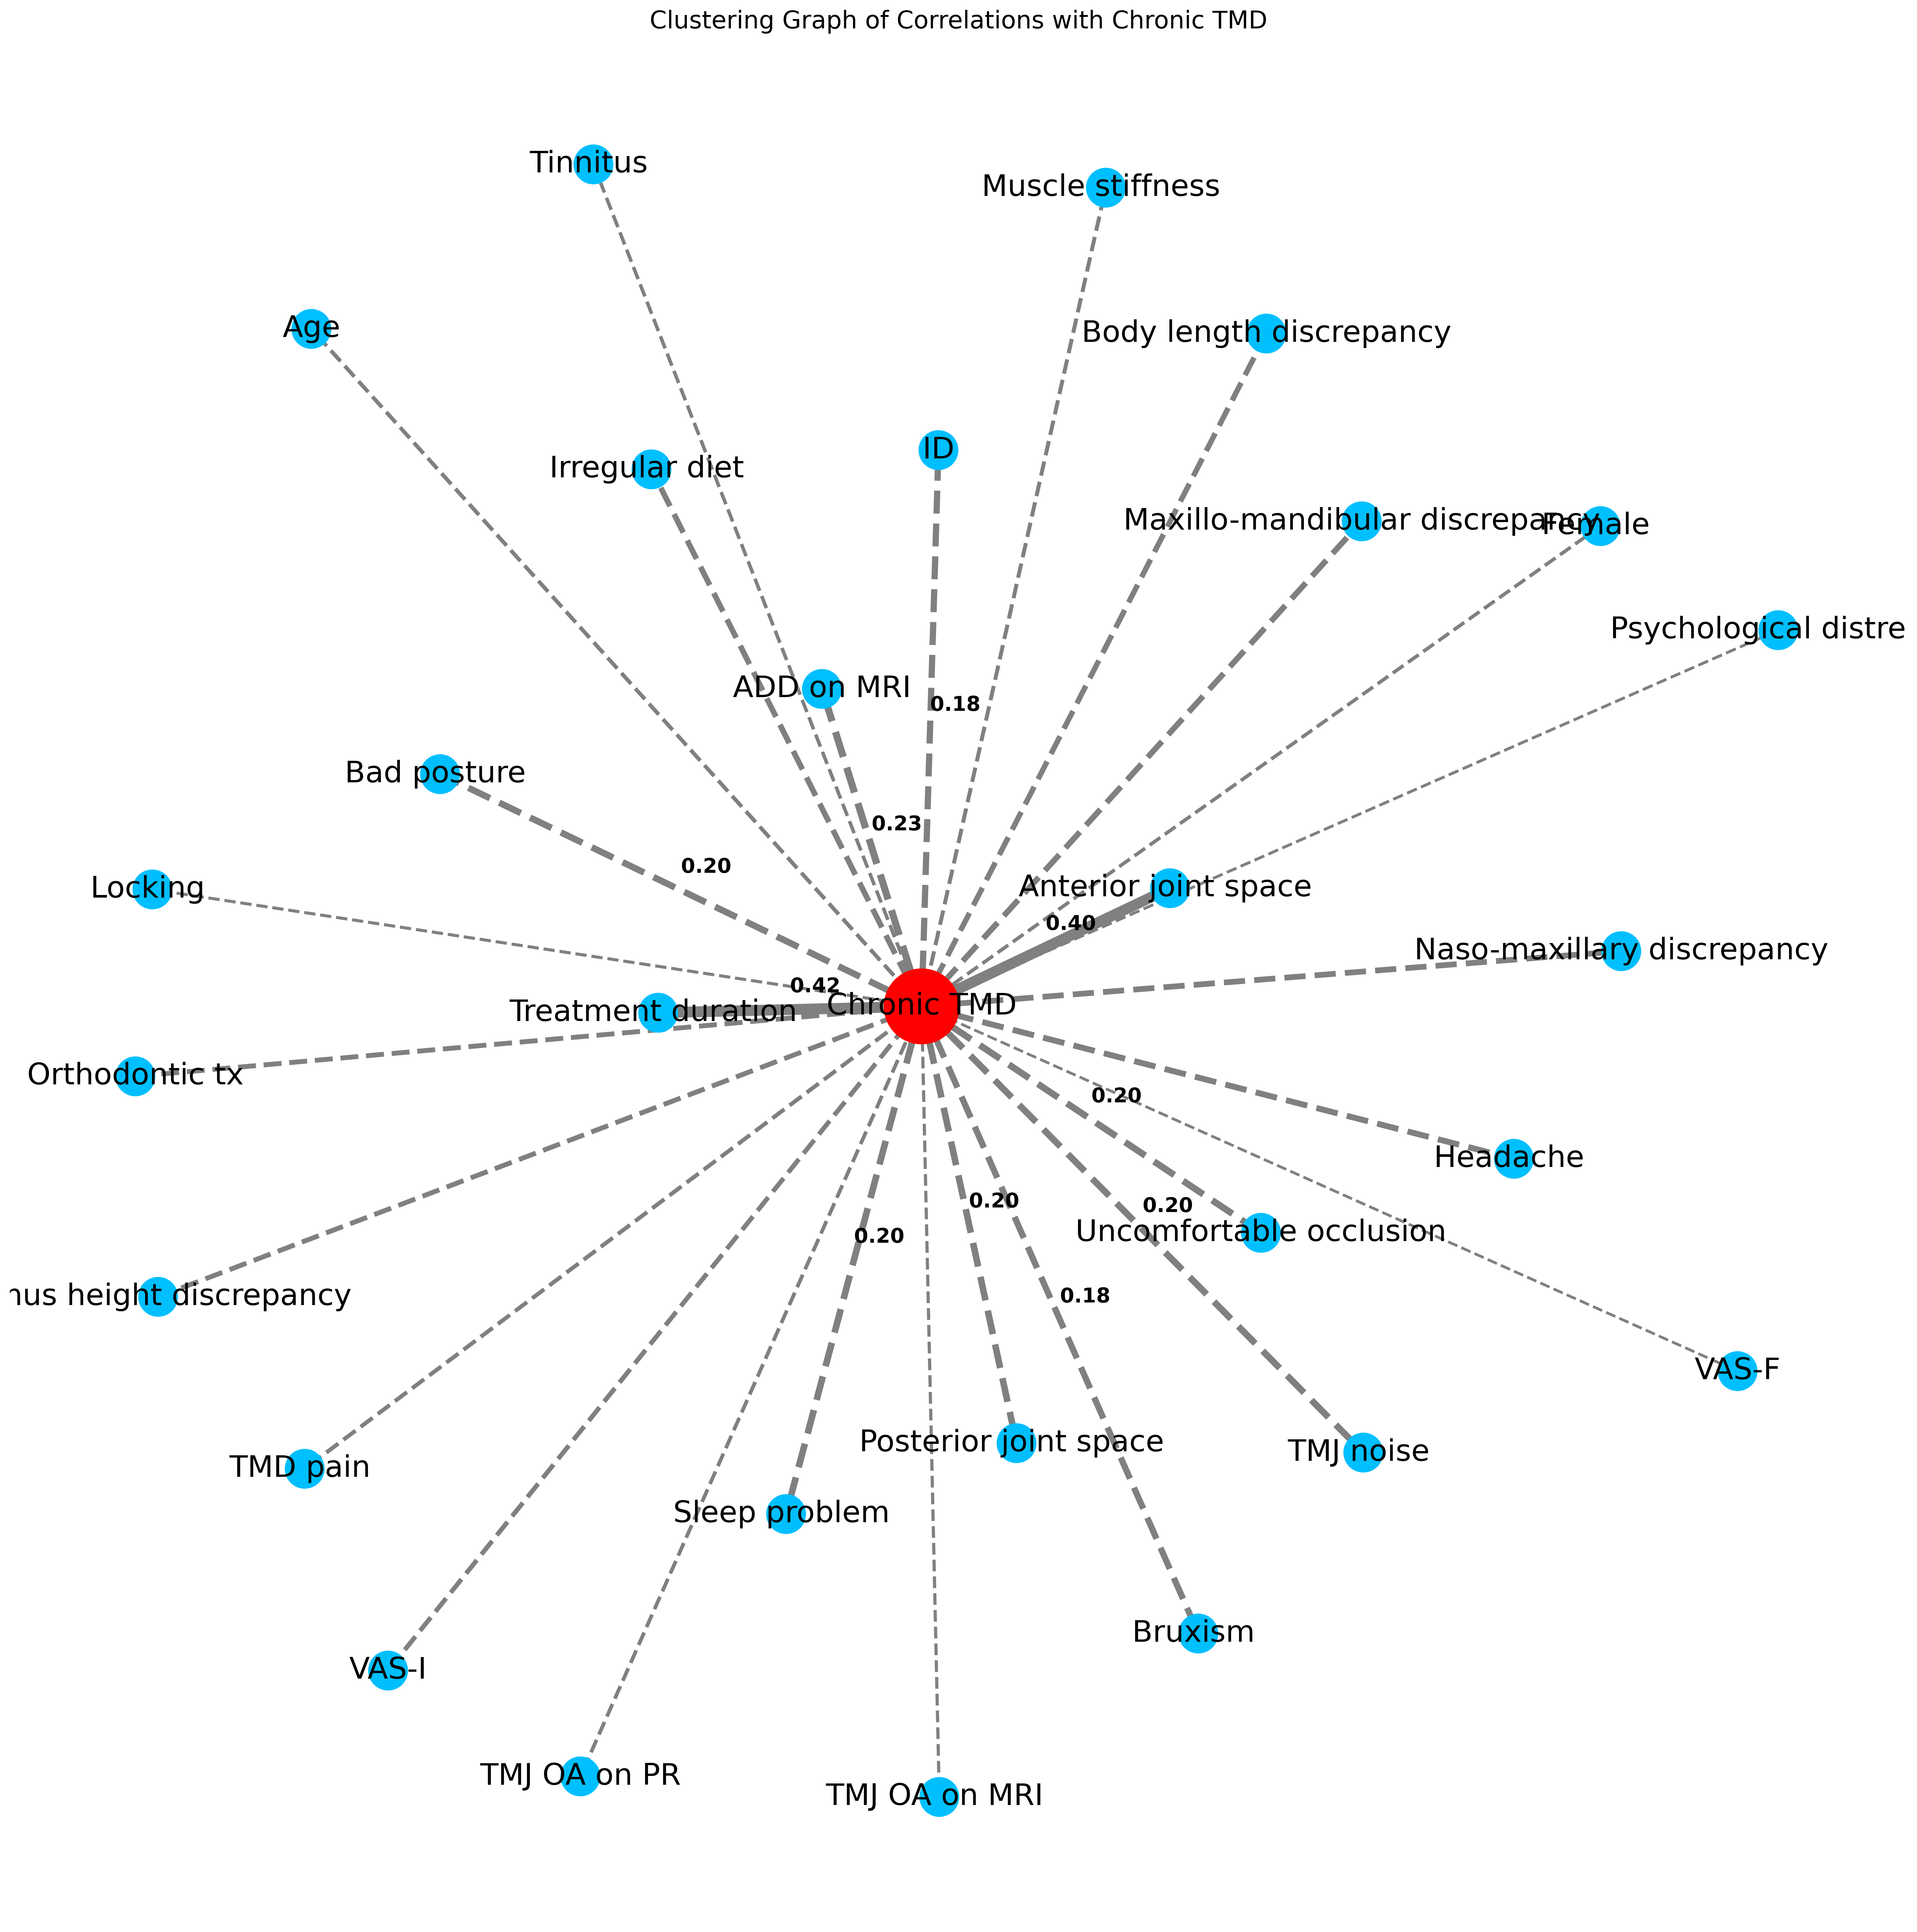

In [6]:
# Acute0Chronic1과 다른 모든 칼럼 간의 Force-Directed Graph
"""
for i in range (4):
    
    if i == 0 : 
        filtered_df = df[df['Age']< 65]
        surfix = 'Age<65'
    if i == 1 : 
        filtered_df = df[df['Age']>= 65]
        surfix = 'Age>=65'
    if i == 2 : 
        filtered_df = df[df['Age']< 85]
        surfix = 'Age<85'
    if i == 3 : 
        filtered_df = df[df['Age']>= 85]
        surfix = 'Age>=85'
        
    target_column = 'Age'
    plot_clustering_graph(filtered_df, target_column, center_color = 'red', save_path = f'./Figure/3_{target_column}_{surfix}')

    target_column = 'VAS'
    plot_clustering_graph(filtered_df, target_column, center_color = 'orange', save_path = f'./Figure/3_{target_column}_{surfix}')

    target_column = 'DJD_DCTMD'
    plot_clustering_graph(filtered_df, target_column, center_color = 'green', save_path = f'./Figure/3_{target_column}_{surfix}')
"""
target_column = 'Chronic TMD'
plot_clustering_graph(df, target_column, center_color = 'red', save_path = f'./Figure/250801_Adolescent_2D.jpeg')
    

In [7]:
def plot_3d_force_directed_correlation(df, target_column, central_node_color='orange', save_path=''):
    G = nx.Graph()

    for col in df.columns:
        if col != target_column:
            correlation = df[target_column].corr(df[col])
            G.add_edge(target_column, col, weight=correlation)

    surrounding_nodes = [node for node in df.columns if node != target_column]
    for i in range(len(surrounding_nodes)):
        for j in range(i + 1, len(surrounding_nodes)):
            node1 = surrounding_nodes[i]
            node2 = surrounding_nodes[j]
            correlation = df[node1].corr(df[node2])
            G.add_edge(node1, node2, weight=correlation)

    pos = nx.spring_layout(G, dim=3, seed=42, scale=2.0)
    pos_adjusted = {node: (x * 1.5, y * 1.5, z * 1.5) for node, (x, y, z) in pos.items()}

    edge_traces = []
    for edge in G.edges(data=True):
        x_edges = [pos_adjusted[edge[0]][0], pos_adjusted[edge[1]][0]]
        y_edges = [pos_adjusted[edge[0]][1], pos_adjusted[edge[1]][1]]
        z_edges = [pos_adjusted[edge[0]][2], pos_adjusted[edge[1]][2]]

        edge_width = max(0.5, abs(edge[2]['weight']) * 10)

        edge_trace = go.Scatter3d(
            x=x_edges, y=y_edges, z=z_edges,
            mode='lines',
            line=dict(color='grey', width=edge_width),
            hoverinfo='none'
        )
        edge_traces.append(edge_trace)

    x_nodes = [pos_adjusted[node][0] for node in G.nodes]
    y_nodes = [pos_adjusted[node][1] for node in G.nodes]
    z_nodes = [pos_adjusted[node][2] for node in G.nodes]

    node_sizes = [40 if node == target_column else 15 + (abs(G[target_column][node]['weight']) * 10) for node in G.nodes]
    node_text_sizes = [26 if node == target_column else 16 for node in G.nodes]  # ✅ 글씨 크기 증가

    central_node_color = 'red' if 'Chronic TMD' in target_column else 'orange' if 'VAS-I' in target_column else 'green' if 'Treatment duration' in target_column else 'red'

    node_trace = go.Scatter3d(
        x=x_nodes, y=y_nodes, z=z_nodes,
        mode='markers+text',
        marker=dict(
            size=node_sizes,
            color=[central_node_color if node == target_column else 'skyblue' for node in G.nodes],
            line=dict(width=2, color='black')  # ✅ 노드 테두리 색상도 검정색
        ),
        text=[node if node != target_column else f"<b>{node}</b>" for node in G.nodes],
        textposition='top center',
        textfont=dict(size=node_text_sizes, color='black'),  # ✅ 텍스트 색상을 검정색으로 지정
        hoverinfo='text'
    )

    fig = go.Figure(data=edge_traces + [node_trace])

    fig.update_layout(
        showlegend=False,
        scene=dict(
            xaxis=dict(showbackground=False, showgrid=False, showticklabels=False),
            yaxis=dict(showbackground=False, showgrid=False, showticklabels=False),
            zaxis=dict(showbackground=False, showgrid=False, showticklabels=False)
        ),
        margin=dict(l=0, r=0, b=0, t=0),
        width=1800,
        height=1200
    )

    pio.write_html(fig, save_path)
    fig.show()

In [10]:
plot_3d_force_directed_correlation(df, 'Chronic TMD', central_node_color = 'Red', save_path = f'./Figure/250801_Adolescent.html')